In [ ]:
ecophs = 20, patience = 3

In [2]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import time 
import tensorflow as tf
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Flatten, MaxPooling2D, Activation, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Nadam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import zipfile 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import keras

In [4]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


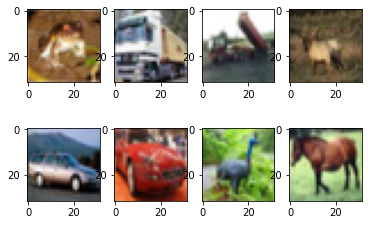

In [5]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


In [6]:
x_train, x_test = imgs[:8000], imgs[8000:10000]
y_train, y_test = clean_labels[:8000], clean_labels[8000:10000]
y_train = tf.cast(y_train, tf.int32)
y_train = tf.one_hot(y_train, depth=10)

In [7]:
y_train

<tf.Tensor: shape=(8000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [9]:
#y_test = tf.keras.utils.to_categorical(y_test) # use this instead of cast, ont_hot

In [10]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [13]:
# convert from integers to floats
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# normalize to range 0-1
x_train = x_train / 255.0
x_test = x_test / 255.0

In [19]:
# define cnn model

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

In [20]:
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

In [22]:
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:

callbacks = [
             EarlyStopping(patience=3)
]
history = model.fit(x_train, y_train, epochs=5, batch_size=64, 
                    validation_data=(x_test, y_test), verbose=0,
                   callbacks=callbacks)

In [27]:
acc = model.evaluate(x_test, y_test, verbose=0)

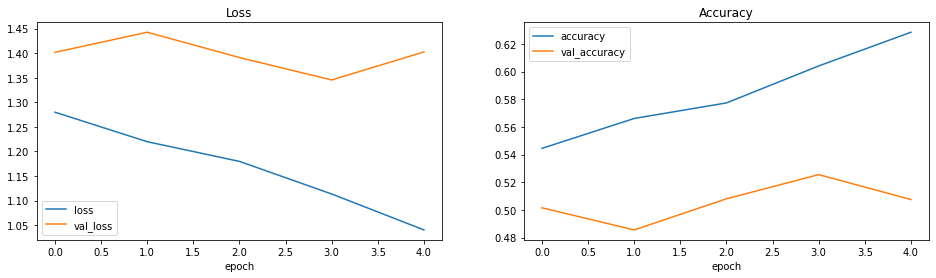

In [32]:
metrics_df = pd.DataFrame(history.history)
fig, ax = plt.subplots(1,2,figsize=(16,4))
metrics_df[["loss","val_loss"]].plot(ax=ax[0]);
ax[0].set_xlabel("epoch");
ax[0].set_title("Loss");
metrics_df[["accuracy","val_accuracy"]].plot(ax=ax[1]);
ax[1].set_xlabel("epoch");
ax[1].set_title("Accuracy");

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
                 kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu',
                 kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu',
                 kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu',
                 kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu',
                 kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu',
                 kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

In [ ]:
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=3)
]
history = model.fit(x_train, y_train, epochs=5, batch_size=64,
                    validation_data=(x_test, y_test), verbose=0,
                    callbacks=callbacks)

In [ ]:
# VGG style with dropout

In [36]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
                 kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu',
                 kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu',
                 kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu',
                 kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu',
                 kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu',
                 kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=3)
]
history = model.fit(x_train, y_train, epochs=20, batch_size=64,
                    validation_data=(x_test, y_test), verbose=0,
                    callbacks=callbacks)

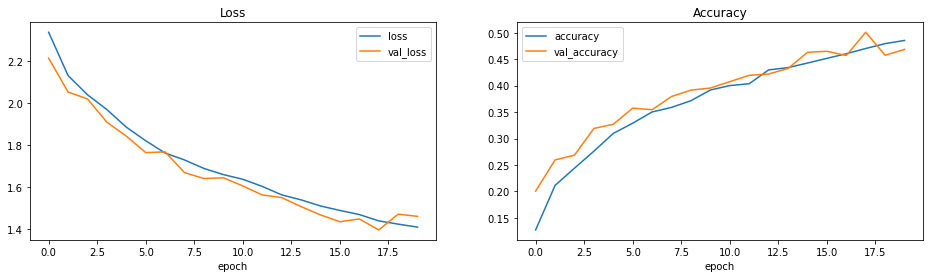

In [37]:
metrics_df = pd.DataFrame(history.history)
fig, ax = plt.subplots(1,2,figsize=(16,4))
metrics_df[["loss","val_loss"]].plot(ax=ax[0]);
ax[0].set_xlabel("epoch");
ax[0].set_title("Loss");
metrics_df[["accuracy","val_accuracy"]].plot(ax=ax[1]);
ax[1].set_xlabel("epoch");
ax[1].set_title("Accuracy");

In [ ]:
# add L2 regularizations

In [40]:
from keras.regularizers import l2
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',
                 padding='same', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',
                 padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform',
                 padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform',
                 padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform',
                 padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform',
                 padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu',
                kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
model.add(Dense(10, activation='softmax'))
# compile model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=3)
]
history = model.fit(x_train, y_train, epochs=20, batch_size=64,
                    validation_data=(x_test, y_test), verbose=0,
                    callbacks=callbacks)

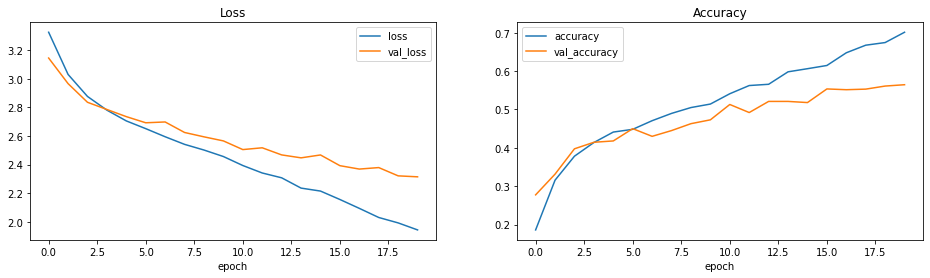

In [41]:
metrics_df = pd.DataFrame(history.history)
fig, ax = plt.subplots(1,2,figsize=(16,4))
metrics_df[["loss","val_loss"]].plot(ax=ax[0]);
ax[0].set_xlabel("epoch");
ax[0].set_title("Loss");
metrics_df[["accuracy","val_accuracy"]].plot(ax=ax[1]);
ax[1].set_xlabel("epoch");
ax[1].set_title("Accuracy");

In [ ]:
# new model 1

In [64]:
from keras.regularizers import l2
modelI = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',
                               padding='same', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',
                               padding='same', kernel_regularizer=l2(0.001)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform',
                 padding='same', kernel_regularizer=l2(0.001)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform',
                 padding='same', kernel_regularizer=l2(0.001)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform',
                 padding='same', kernel_regularizer=l2(0.001)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform',
                 padding='same', kernel_regularizer=l2(0.001)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),
        
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu",
                kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)),
        tf.keras.layers.Dense(10, activation="softmax")


    ]
)


In [65]:

modelI.compile(optimizer=tf.keras.optimizers.Nadam(0.001),
               loss=tf.keras.losses.CategoricalCrossentropy(),
               metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=3)
]

history = modelI.fit(x_train, y_train, batch_size=128, epochs=20,
                     validation_split=0.2, validation_data=(x_test, y_test), callbacks=callbacks)

print("--- model took %s seconds ---" % (time.time() - start_time))

Epoch 1/20
50/50 [==============================] - 15s 285ms/step - loss: 3.3264 - accuracy: 0.1658 - val_loss: 3.1167 - val_accuracy: 0.1731
Epoch 2/20
50/50 [==============================] - 13s 270ms/step - loss: 2.8575 - accuracy: 0.2720 - val_loss: 2.6025 - val_accuracy: 0.3594
Epoch 3/20
50/50 [==============================] - 14s 276ms/step - loss: 2.5280 - accuracy: 0.3636 - val_loss: 2.4089 - val_accuracy: 0.4062
Epoch 4/20
50/50 [==============================] - 14s 276ms/step - loss: 2.3436 - accuracy: 0.4098 - val_loss: 2.4022 - val_accuracy: 0.3719
Epoch 5/20
50/50 [==============================] - 14s 283ms/step - loss: 2.1664 - accuracy: 0.4439 - val_loss: 2.0983 - val_accuracy: 0.4563
Epoch 6/20
50/50 [==============================] - 14s 286ms/step - loss: 2.0534 - accuracy: 0.4867 - val_loss: 1.9939 - val_accuracy: 0.4881
Epoch 7/20
50/50 [==============================] - 14s 286ms/step - loss: 1.9460 - accuracy: 0.5100 - val_loss: 1.9871 - val_accuracy: 0.4969

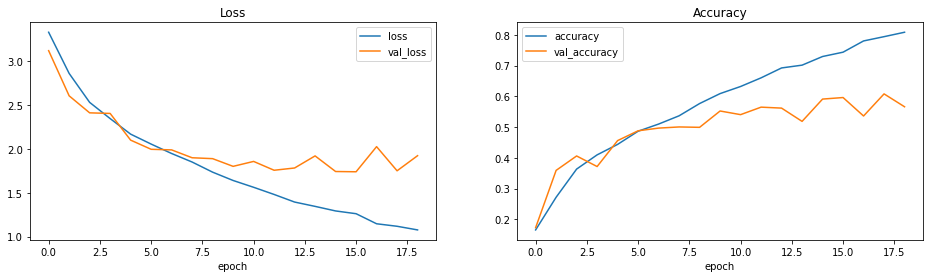

In [67]:
metrics_df = pd.DataFrame(history.history)
fig, ax = plt.subplots(1,2,figsize=(16,4))
metrics_df[["loss","val_loss"]].plot(ax=ax[0]);
ax[0].set_xlabel("epoch");
ax[0].set_title("Loss");
metrics_df[["accuracy","val_accuracy"]].plot(ax=ax[1]);
ax[1].set_xlabel("epoch");
ax[1].set_title("Accuracy");

In [68]:
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...
    image = tf.reshape(image, ((1,) + image.shape))
    predictions = modelI.predict(image)
    
    return np.argmax(predictions)

In [70]:
 y_test = clean_labels[8000:10000]

In [71]:
from sklearn.metrics import accuracy_score
test_predictions = np.empty(0)
for image in x_test: 
    prediction = model_I(image)
    test_predictions = np.append(test_predictions, prediction)
print("Model_I Testing accuracy: " + str(accuracy_score(y_test, test_predictions)))


Model_I Testing accuracy: 0.5715
